<a href="https://colab.research.google.com/github/vicdlp/CS_project/blob/main/CS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries:

In [1]:
!pip install biopython # Install the biopython library which contains the SeqIO module.
from Bio import SeqIO # to read protein sequences
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import seaborn as sns
from cycler import cycler


colors = sns.color_palette("deep", n_colors=15)

# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8')

# Set the fontsize for various plot elements
plt.rcParams.update({
    'font.size': 20,            # General font size
    'axes.titlesize': 22,       # Title font size
    'axes.labelsize': 20,       # Axis label font size
    'xtick.labelsize': 18,      # X-tick label font size
    'ytick.labelsize': 18,      # Y-tick label font size
    'legend.fontsize': 16,      # Legend font size
    'figure.figsize': (12, 8),  # Set default figure size
    'legend.frameon': True,
    'legend.edgecolor' : '0.1',
    'axes.prop_cycle': cycler(color=colors)
})


# Task 1 : Pre-processing of data and One-Hot encoding

  After reading the data from the ".fasta" files, the goal is to convert the protein sequences of our data set into variables that will be easier to manipulate numerically. The sequences are made of the 20 amino-acids (AA), and the alignment gap "-". They are of the form, for example : "--ATHG--MPPQR...", and are each of length 96.


  The first idea would be to associate a value to each AA and to store the sequence in a 96 dimensional vector. However this would create a distance relationship between amino-acids, because the AA labeled with 20 would be much closer (for the computer that didn't study biology) to the one labeled 19, than to the one labeled with 1, which is not true in reality, because there is no order relationship between AA (they are just the elementary bricks of a sequence, and labeling them with another number shouldn't change their relationships).

  Therefore, we must use one-hot encoding, which consist to uniquely associate each AA, not with a number, but with one of the 21 vectors of the canonical basis of $\mathbb{R}^{21}$. This keeps all the AAs equidistant (for Euclidean distance, for example, $\sqrt{2}$). But our sequences are 96 AA long, so if we want to store each sequence as a datapoint, we must store it in a $21\times 96 = 2016$-dim vector.

  This is the content of the following sequences

In [2]:
nat = list(SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")) # Natural data sampled from experiments

art = list(SeqIO.parse("MSA_art.faa", "fasta")) # Artificial data sampled from the generative model

In [3]:
def one_hot(sequence): # Converts a single sequence of length 96 to a 96 x 21 = 2016 dimensional vector

  matrix = np.zeros((96,21)) # matrix to store the encoded data

  # Dictionary that converts amino-acids to a number between 0 and 20
  amino_acids = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 'Q':13, 'R':14, 'S':15, 'T':16, 'V':17, 'W':18, 'Y':19, '-':20}

  for i in range(96): # for the i-th amino-acid of the sequence ...
    matrix[i, amino_acids[sequence[i]]] = 1 # ... associate the corresponding 21 dim vector in column i

  return matrix.flatten() # return the flatten matrix to get the data-point as a vector



def encode(data): # Converts the dataset to a matrix containing the one-hot encoded sequences

  matrix = np.zeros((len(data),2016))

  for i in range(len(data)):
    matrix[i] = one_hot(data[i].seq)

  return matrix


def label(data): # Extracts the labels of the dataset : Functional sequence (y=1) or Non Functional sequence (y=0)
  label = np.zeros(len(data))
  for i in range(len(data)):
    if re.search(r"functional_true", data[i].description):
      label[i] = 1
    else:
      label[i] = 0

  return label

def de_one_hot(X):
  amino_acids = {0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8:'K', 9:'L', 10:'M', 11:'N', 12:'P', 13:'Q', 14:'R', 15:'S', 16:'T', 17:'V', 18:'W', 19:'Y', 20:'-'}
  sequence = ''
  for i in range(96):
      sequence += amino_acids[np.argmax(X[i])]
  return sequence


In [4]:
# testing if the encoding/decoding works

print(de_one_hot(one_hot(nat[0].seq).reshape(96,21)))
print(nat[0].seq)

-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH
-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Rescaling the data : x' = (x-mu)/sigma

# Natural sequences dataset
X_nat = encode(nat)
y_nat = label(nat)

scaler.fit(X_nat)
X_nat = scaler.transform(X_nat)

# Artificial sequences dataset
X_art = encode(art)
y_art = label(art)

scaler.fit(X_art)
X_art = scaler.transform(X_art)

Rescaling is useful to give the same importance to all features, as their range can vary drastically, but here, it seems that all the 2016 features were already centered and had approximatively the same variance. This is probably a consequence of our encoding.

# Task 2 : Principal Component Analysis

So far, we have embedded our data in a 2016-dim. space. But none of these dimension has a clear physical interpretation and we cannot interpret them just by looking at a data point. However, we can try to implement dimensional reduction, in order to get a grasp of the signal hidden in the noise. Indeed, if we can go from 2016 to 2 dimension, we will be able to plot our data points, and see if we can observe any charachteristics of the dataset. For this, we have at our disposal Principal Component Analysis (PCA). It consists of computing the Sample Covariance Matrix : $$C_{ij} = \frac{1}{M-1} \sum_{k=1}^M X_{i}^kX_j^k$$ where $X_i^k$ is the composant $i$ of the $k$-th data point. It is a $2016\times 2016$ matrix that gives an estimation over the dataset of how the variable $X_i$ is correlated to the variable $X_j$. Then, when looking at the eigenvalues of this matrix (also called the principal components of the dataset, hence the name of this method), we will typically that there is a few large eigencalues and that most of the others are very small. Thus by keeping only the first 2 biggest eigenvalues we can extract a significant part of the signal contained in the data while only having a few variables instead of 2016. These principal components also don't have a clear physical interpretation, but they significantly help to understand the underlying structure of the data.

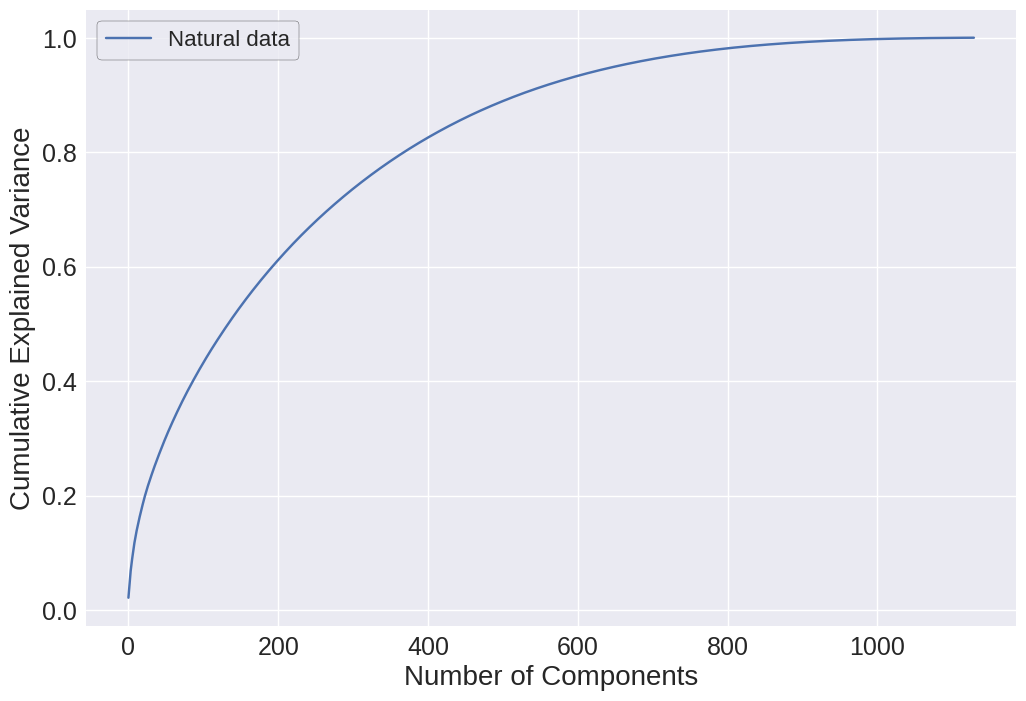

The explained variance ratio for the first two dimension of the natural data is  3.78 %
The number of components needed to keep 90% of the signal is 522


In [6]:
from sklearn.decomposition import PCA

# Fit PCA without specifying the number of components to compute variance ratios for all components
pca_nat = PCA().fit(X_nat)
evr_nat = np.cumsum(pca_nat.explained_variance_ratio_)
compression = PCA(0.9)
X_nat_pca_nat = compression.fit_transform(X_nat)

# Plot the cumulative explained variance as a function of the number of components
plt.figure()
plt.plot(evr_nat, label = "Natural data") # Cumulative sum of explained variance
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

print("The explained variance ratio for the first two dimension of the natural data is ", round(evr_nat[1]*100,2), '%')
print("The number of components needed to keep 90% of the signal is", compression.n_components_)

As expected, signal is not uniformly distributed along all directions of the embedding space. However if we only keep the first 2 dimension we, will keep only 3.78% of the signal in the data, and that in order to keep 90% of the signal we would need 522 components. Moreover, we can note that we only have around 1000 singular values and not 2016, this is because we have more features than data points, thus all the other singular values are zero. This tells us that we should not try to interpret too much the 2D projection of the data points as it cannot really capture the complexity of this dataset. Nevertheless, it can still be useful to see how it looks like. Moreover, we will be able later when doing more complicated tasks (like DNN and Boltzmann machines) to feed our model with dimensionnally reduced data (thus losing a bit of signal), but this should help considerably the training time.

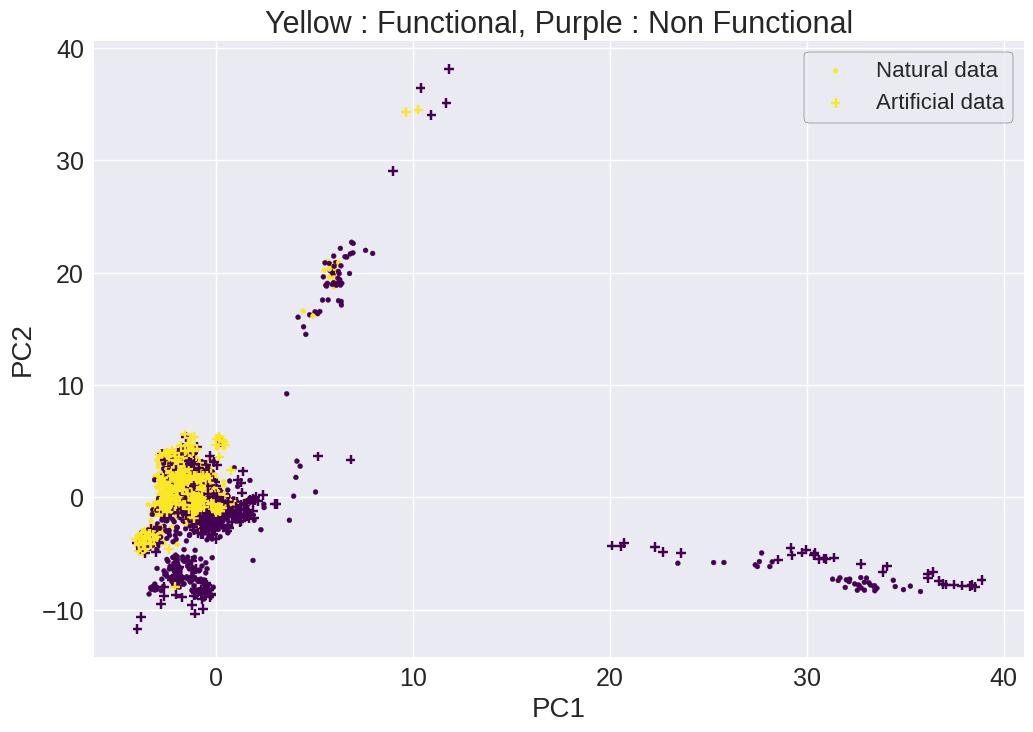

In [7]:
pca = PCA(n_components=2)

X_nat_pca = pca.fit_transform(X_nat) # Finding the 2 PCs of the Natural data and projecting the data onto them
X_art_pca = pca.transform(X_art) # Projecting the Artificial data on the 2 PCs of the Natural data

plt.figure()
plt.scatter(X_nat_pca[:, 0], X_nat_pca[:, 1], c=y_nat, cmap='viridis', label = "Natural data", marker = ".")

plt.scatter(X_art_pca[:, 0], X_art_pca[:, 1], c=y_art, cmap='viridis', label = "Artificial data", marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Yellow : Functional, Purple : Non Functional')
plt.show()

We can see that functional and non functional are not well separted in PCA space, except in the line of points in the bottom-right corner. Thus we cannot infer wether a sequence is functional or not given its two PCs. But we can zoom on the main cloud of points to see if we can see any separation.

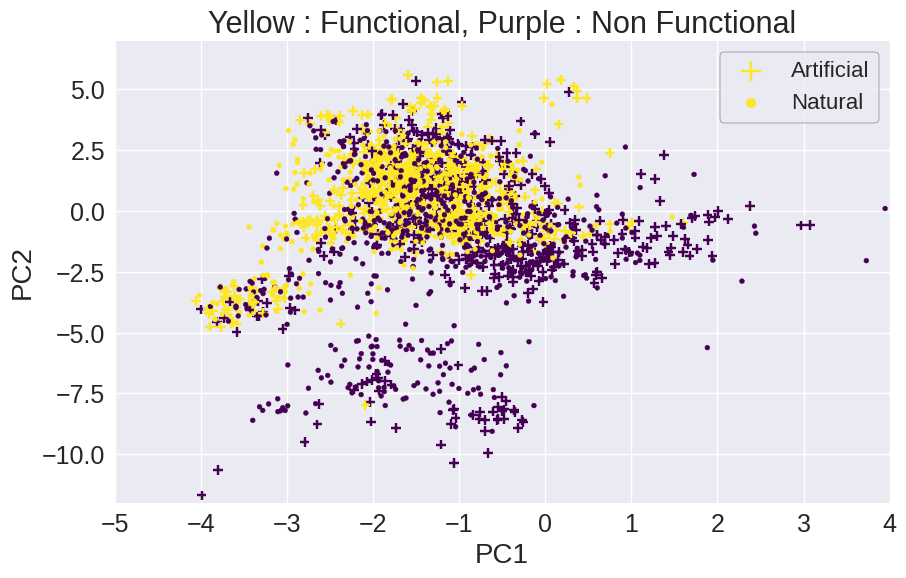

In [8]:
# Zoom on the cloud of points

plt.figure(figsize=(10, 6))

plt.xlim(-5,4)
plt.ylim(-12,7)

plt.scatter(X_art_pca[:, 0], X_art_pca[:, 1], c=y_art, cmap='viridis', label = "Artificial", marker = "+")
plt.scatter(X_nat_pca[:, 0], X_nat_pca[:, 1], c=y_nat, cmap='viridis', label = "Natural", marker = ".")

plt.legend(markerscale = 2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Yellow : Functional, Purple : Non Functional')
plt.show()

Maybe in the lower part of the cloud, more points are non functional, but in the rest it is mixed.

A problem with PCA, is the fact that it is only able to perform linear transformations. But tipically data cannot be perfectly mapped to a smaller dimension without crossing itself. This means that initially far away points will get mapped to the same point. Another method to do dimensional reductional while taking into account this challenge is t-SNE. It is a non-linear transformation of the data, that aims at getting initially close points closer and getting initially far points even further. However, this non linear is not an explicit function and is only the result of an algorithm trying to minimize a Kullback-Leibler divergence for a given set of points. Thus if I add a point, I cannot get his mapping through the previous non-linear transform, and I have to start over. Again, it should not be interpreted too much but it is still useful tool, especially to understand the difference between the artificial and natural datapoints.

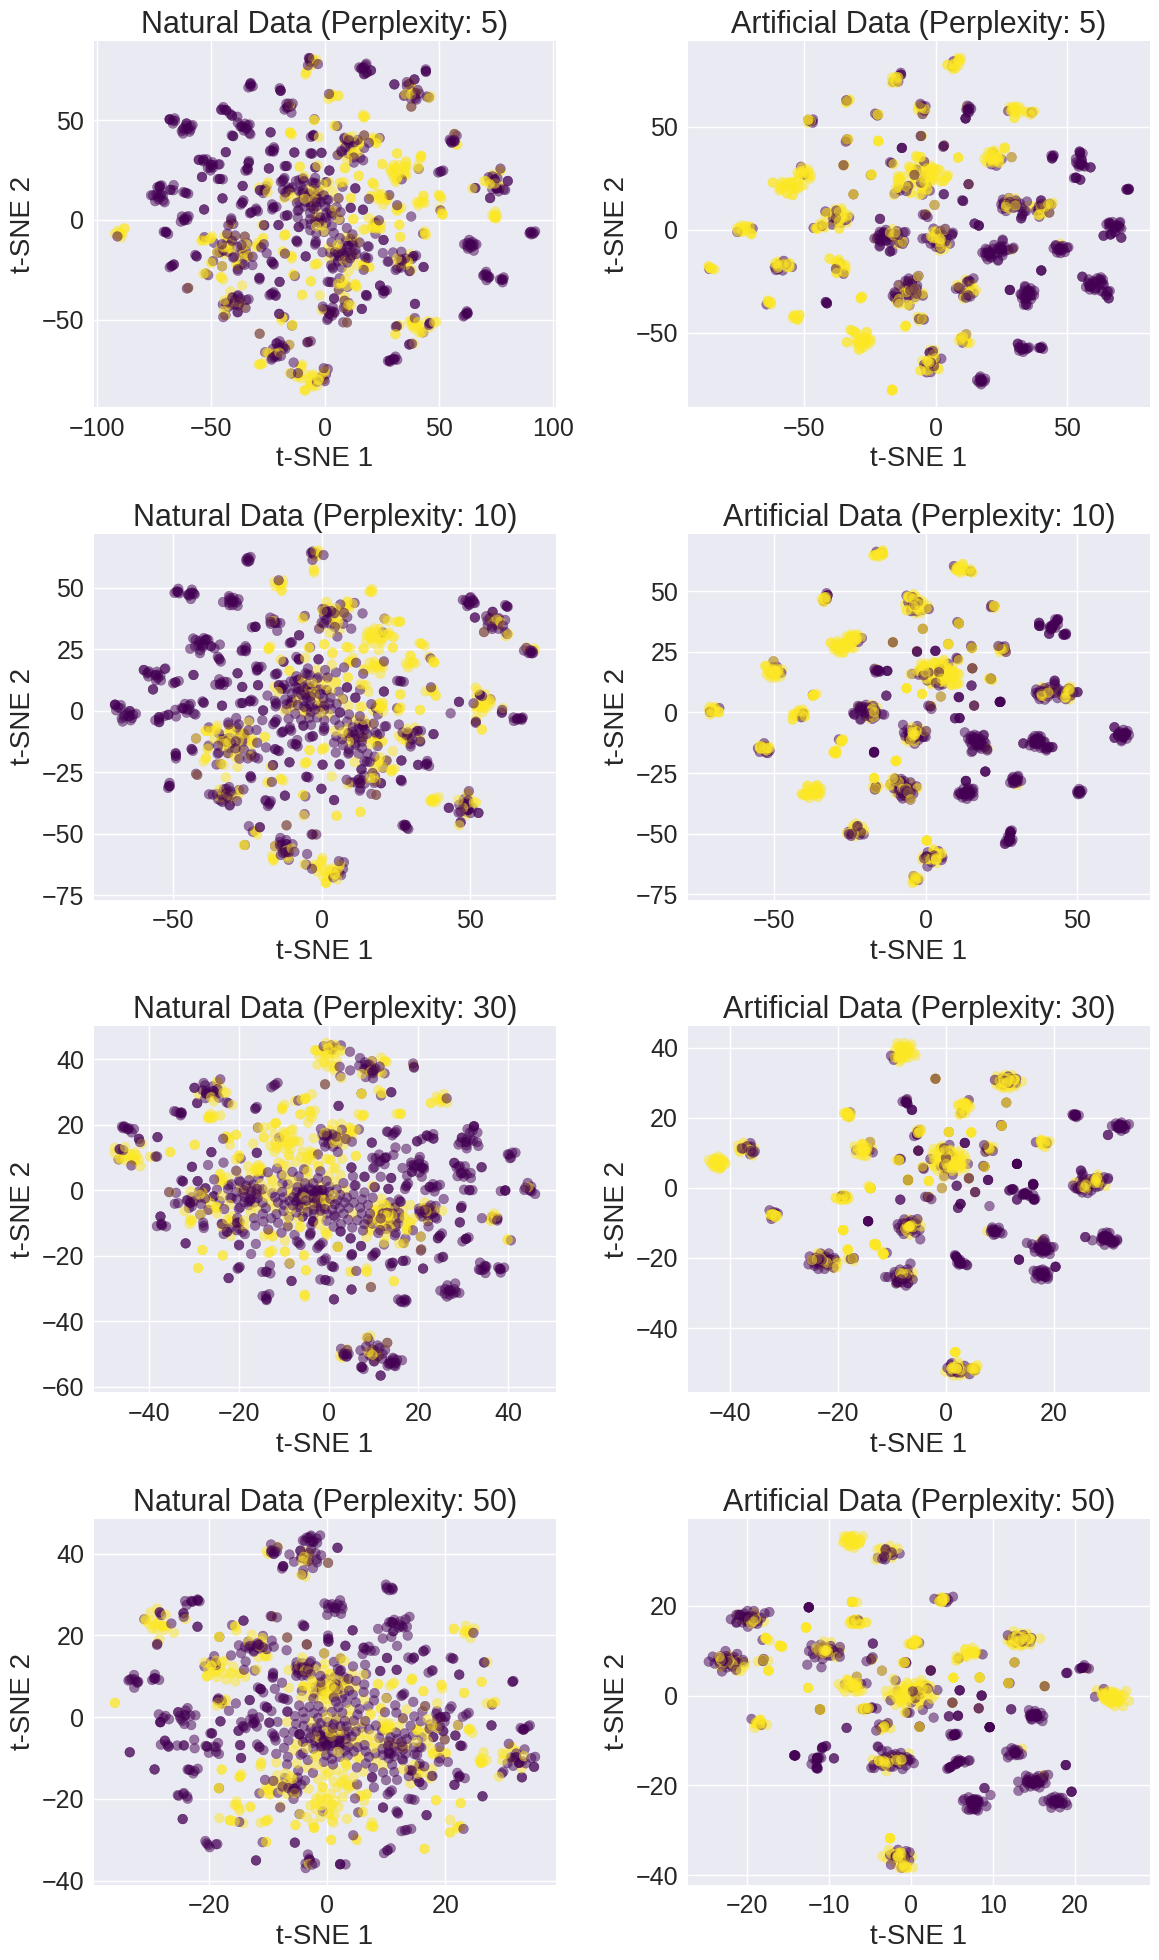

In [9]:
from sklearn.manifold import TSNE


# first using PCA to speed up t-SNE training
pca = PCA(n_components=800)
X_nat_pca = pca.fit_transform(X_nat)
X_art_pca = pca.transform(X_art)

# Define perplexity values to explore
perplexities = [5, 10, 30, 50]

# Create a figure and subplots
fig, axes = plt.subplots(nrows=len(perplexities), ncols=2, figsize=(12, 20))
plt.title("t-SNE for different perplexities (Yellow : F, Purple : NF)")

# Iterate through perplexity values and datasets
for i, perplexity in enumerate(perplexities):
    # Apply t-SNE for current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)  # Added random_state for reproducibility

    # Fit and transform for both datasets
    X_art_embedded = tsne.fit_transform(X_art_pca)
    X_nat_embedded = tsne.fit_transform(X_nat_pca)

    # Plot natural data on the first column
    axes[i, 0].scatter(X_nat_embedded[:, 0], X_nat_embedded[:, 1], c=y_nat, cmap='viridis', label="Natural", alpha = 0.5)
    axes[i, 0].set_title(f'Natural Data (Perplexity: {perplexity})')
    axes[i, 0].set_xlabel('t-SNE 1')
    axes[i, 0].set_ylabel('t-SNE 2')

    # Plot artificial data on the second column
    axes[i, 1].scatter(X_art_embedded[:, 0], X_art_embedded[:, 1], c=y_art, cmap='viridis', label="Artificial", alpha = 0.5)
    axes[i, 1].set_title(f'Artificial Data (Perplexity: {perplexity})')
    axes[i, 1].set_xlabel('t-SNE 1')
    axes[i, 1].set_ylabel('t-SNE 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Even t-SNE cannot separate F and NF sequences (Yellow and Purple datapoints), and for multiple perplexities. This means that F and NF are relatively close in the feature space. However, the result of the algorithm is quite different for artificial and natural data. Artificial data tend to be mapped to multiple small blobs, while natural data are mapped to a blurred blob. This cannnot be interpreted right away, because the mapping is specific to the dataset, but the same algorithm will have different behaviour on the artificial and natural sequences.


To conclude on PCA, for a given label (F or NF), if we plot them on the same graph, we can see that almost everywhere, artificial and natural data overlap. This means that the generated sequence have quite well captured the statistical distribution of the natural sequences, which means that the generative model has done a good job. However, there is still a difference in the diagonal blob at the top. We can see that artificial and natural datapoints are clearly mapped splitted in two different areas, which tells us that maybe, the generative model is missing out some properties.

# Task 3 : Clustering

Clustering consists is a unsupervised learnin task. It aims at clustering data points based on similarities. For k-means, the algorithm tries to find k cluster centers and assign each point to a cluster such that the distance between all points and their cluster center is minimized. The question we will try to answer here is wether the clustering algorithm manages to separate Functional and Non Functional sequences. For this we will check after the clustering has converged if each culster is a mix of F and NF sequences or if it is well separated. We therfore define the Score of a cluster as :

$$ \text{Score } = \frac{\text{Number of F sequences in the cluster}}{\text{Total number of sequences in the cluster}} $$

If the score is 1, then all sequences in the cluster are functional, if it is 0, then all sequences are NF. and if the score is in between, then the clusters are mixed.



### A) K-means

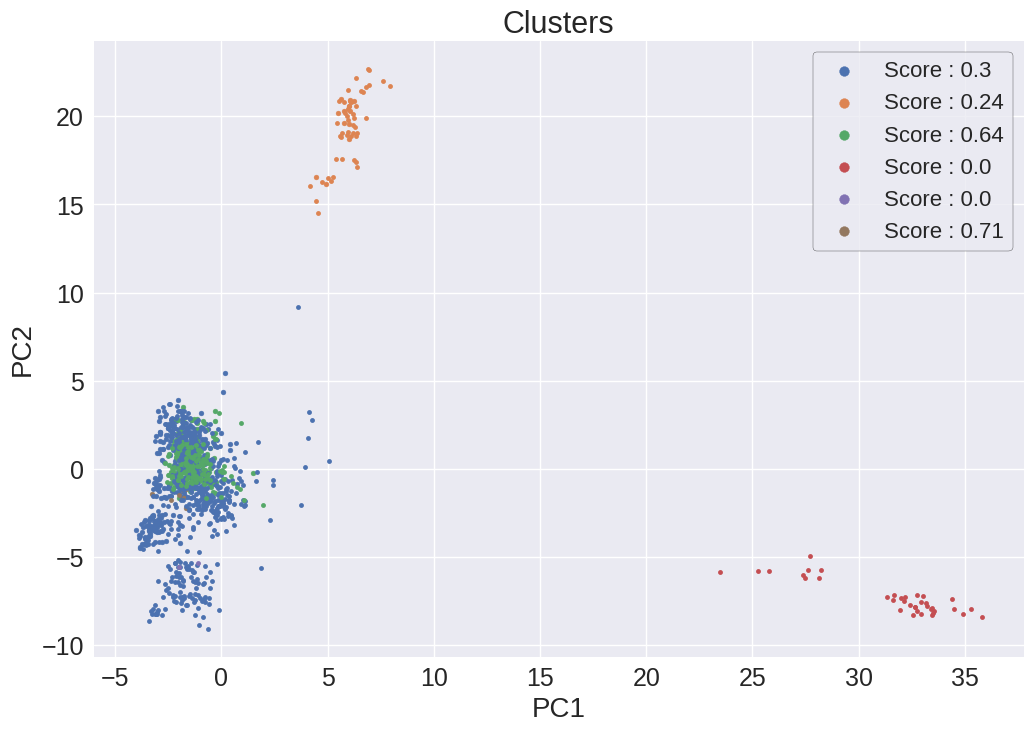

In [10]:
from sklearn.cluster import KMeans

k = 6 # Number of clusters

# Apply KMeans clustering to the natural data only
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_nat)  # Fit KMeans

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

plt.figure(figsize=(12,8))

for i in range(k): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_nat_pca[mask]
  y_cluster = y_nat[mask]

  X_cluster_F = X_cluster[y_cluster == 1]
  X_cluster_NF = X_cluster[y_cluster == 0]
  cluster_score = round(len(X_cluster_F)/(len(X_cluster_NF)+len(X_cluster_F)),2)

  plt.scatter(X_cluster_F[:, 0], X_cluster_F[:, 1], marker = '.', label = f'Score : {cluster_score}')
  plt.plot(X_cluster_NF[:, 0], X_cluster_NF[:, 1], '.')

plt.legend(markerscale = 2)
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


k means for k=6 clusters does not manage to separate F and NF sequences, except the line of points in the bottom-right corner, where all the sequences are non functional (but we were able to see it by ourselves with our bare eyes, without any algorithm, so we do not learn much from this cluster). For the other clusters, F and NF sequences are clustered together, which means that F and NF cannot be differentiated just by looking at distances between points. We could try to use a different clustering algorithm that avoids this caveat, for instance DBScan, abd focus on the main blob.

### B) Density Based Scan

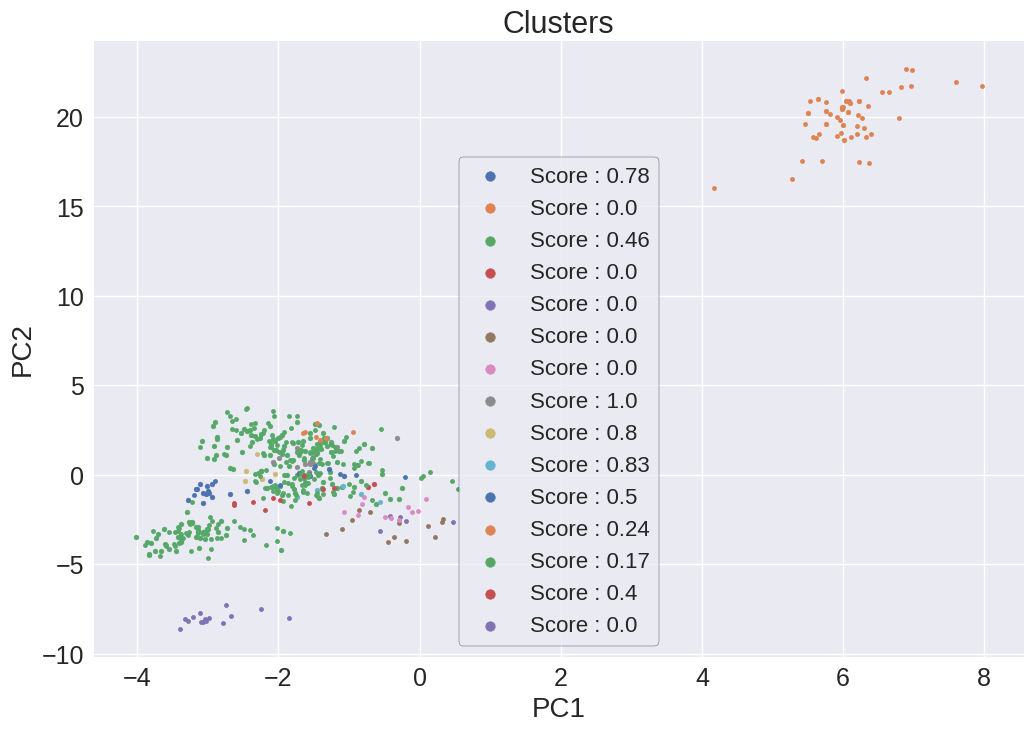

In [11]:
from sklearn.cluster import DBSCAN

eps = 40 # size of directly reachable area

# Apply dbscan clustering to the natural data only
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(X_nat)  # Fit of dbscan

# Get cluster labels for each data point
cluster_labels = dbscan.labels_

plt.figure(figsize=(12,8))


for i in range(max(dbscan.labels_)+1): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_nat_pca[mask]
  y_cluster = y_nat[mask]

  X_cluster_F = X_cluster[y_cluster == 1]
  X_cluster_NF = X_cluster[y_cluster == 0]
  cluster_score = round(len(X_cluster_F)/(len(X_cluster_NF)+len(X_cluster_F)),2)

  # ...plot the cluster in PCA space with F or NF as markerstyle

  plt.scatter(X_cluster_F[:, 0], X_cluster_F[:, 1], marker = '.', label = f'Score : {cluster_score}')
  plt.plot(X_cluster_NF[:, 0], X_cluster_NF[:, 1], '.')

plt.legend(markerscale = 2)
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

DBScan does a little bit better job at clustering the F and NF seperately. Many clusters have only NF sequences while there is only one cluster with only F sequences. This means that F sequences are hard to isolate, and that during classification we will have more False Negatives than False Positives. But the rest of the clusters are still mixed, which indicates that the data has a very twisted high dimensional shape.

### C) Artificial and Natural sequences clustering

Now, we will try to see if the clustering algorithm is able to differentiate artificial and natural data. For this we also define a score, which indicates if clusters are mixed or not.

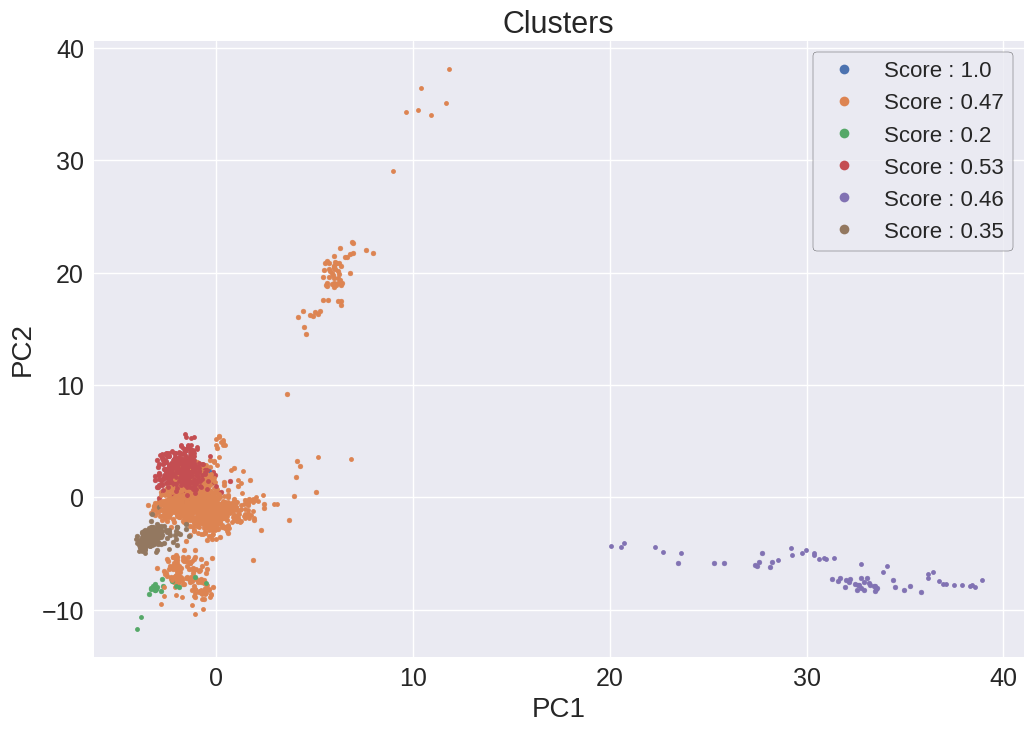

In [12]:
X = np.concatenate((X_nat, X_art))
X_pca = pca.transform(X)
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_art)))) # labels : 0 for natural data, 1 for artificial data

k = 6 # Number of clusters

# Apply KMeans clustering to the natural data only
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)  # Fit KMeans

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

plt.figure(figsize=(12,8))

for i in range(k): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_pca[mask]
  y_cluster = y[mask]

  X_cluster_nat = X_cluster[y_cluster == 0]
  X_cluster_art = X_cluster[y_cluster == 1]
  cluster_score = round(len(X_cluster_art)/(len(X_cluster_nat)+len(X_cluster_art)),2)

  # ...plot the cluster in PCA space

  plt.scatter(X_cluster_nat[:, 0], X_cluster_nat[:, 1], marker = '.')
  plt.plot(X_cluster_art[:, 0], X_cluster_art[:, 1], '.', label= f'Score : {cluster_score}')

plt.legend(markerscale = 2, loc = 1)
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Even with 6 clusters, kmeans is not able to tell apart natural and artificial sequences, which is a good sign for the quality of the generative model.

Then we try to see if the DBSCAN algorithm is able to differentiate artificial and natural data.

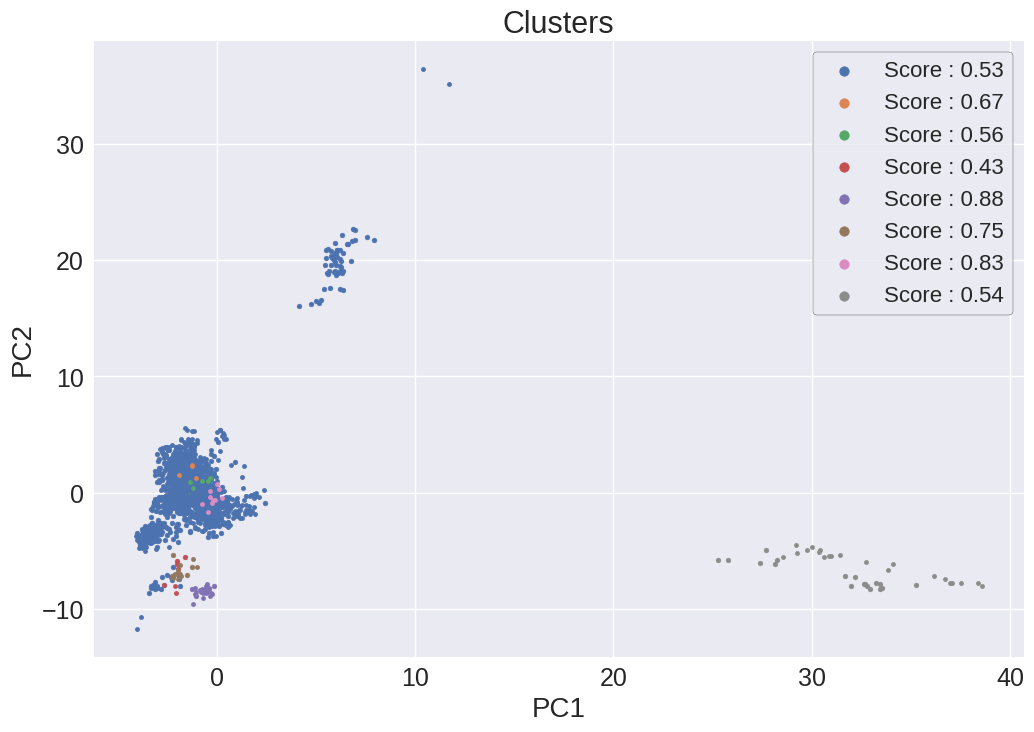

In [13]:
from sklearn.cluster import DBSCAN

eps = 45 # size of directly reachable area

X = np.concatenate((X_nat, X_art))
X_pca = pca.transform(X)
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_art)))) # labels : 0 for natural data, 1 for artificial data

dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(X)


# Get cluster labels for each data point
cluster_labels = dbscan.labels_

plt.figure(figsize=(12,8))

for i in range(max(dbscan.labels_)+1): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_pca[mask]
  y_cluster = y[mask]

  X_cluster_nat = X_cluster[y_cluster == 0]
  X_cluster_art = X_cluster[y_cluster == 1]
  cluster_score = round(len(X_cluster_art)/(len(X_cluster_nat)+len(X_cluster_art)),2)


  # ...plot the cluster in PCA space with F or NF as markerstyle

  plt.scatter(X_cluster_nat[:, 0], X_cluster_nat[:, 1], marker = '.', label = f'Score : {cluster_score}')
  plt.plot(X_cluster_art[:, 0], X_cluster_art[:, 1], '.')

plt.legend(markerscale = 2)
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

It does not do so much better job than K-MEANS since almost all clusters are mixed with artificial and natural sequences. Again it is a good sign for the quality of the generative model.

# Task 4 : Classification



### A) Logistic Regression
Classification is a supervised learning task. It aims at assigning a label to a data point, after having been trained on a set of labeled points.

We used L1 penalty (LASSO regularization) for better results.


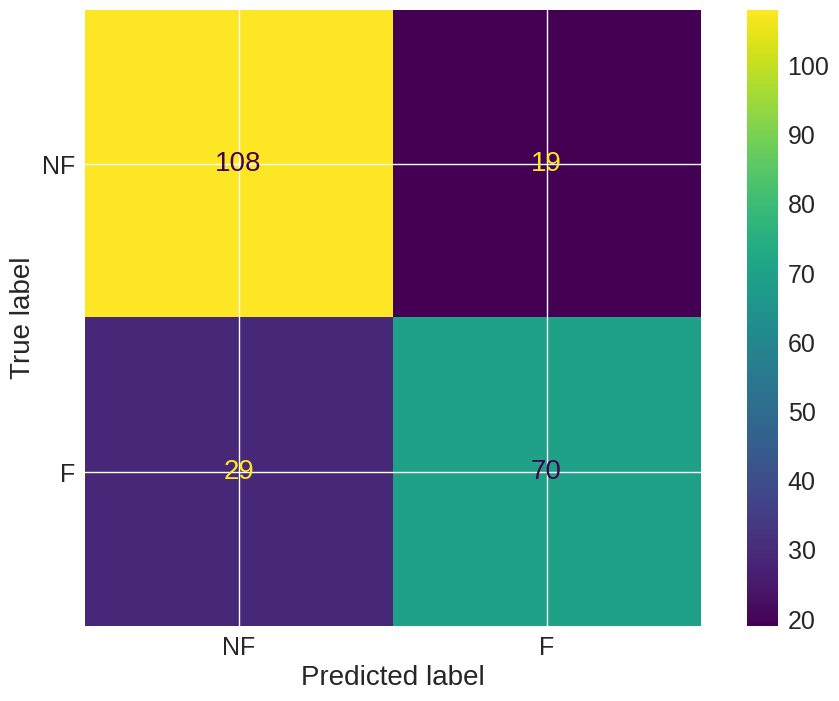

Accuracy of Logistic regression on validation set :  0.7876106194690266
Accuracy of Logistic regression on test set :  0.7607178464606181


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Splitting the natural data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_nat, y_nat, test_size=0.2, random_state=1)

# Loistic regression
log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear') # with LASSO regularization
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)


# Confusion matrix on the validation set
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["NF","F"])
disp.plot()
plt.show()

print("Accuracy of Logistic regression on validation set : ", log_reg.score(X_val, y_val))
print("Accuracy of Logistic regression on test set : ", log_reg.score(X_art, y_art))


Quite a bad performance ($\approx$75% accuracy) on both validation and test set. Remember that a random classifier (randomly assigning a label to a sequence) would have a 50% accuracy. If we remove the "easy to calssify" points (the points in the lower right corner in pca space), the accuracy drops down even more ($\approx$60%) :

In [15]:
pca = PCA(n_components=2)
pca.fit(X_nat)

# Selecting the main blob in PCA space
X_nat_pca = pca.transform(X_nat)
X_nat_main = pca.inverse_transform(X_nat_pca[X_nat_pca[:,0] < 20])
X_art_pca = pca.transform(X_art)
X_art_main = pca.inverse_transform(X_art_pca[X_art_pca[:,0] < 20])

y_nat_main = np.zeros(0)
for i in range(len(y_nat)):
  if X_nat_pca[i,0] < 20:
    y_nat_main = np.append(y_nat_main, y_nat[i])

y_art_main = np.zeros(0)
for i in range(len(y_art)):
  if X_art_pca[i,0] < 20:
    y_art_main = np.append(y_art_main, y_art[i])


# Training on the main blob
# X_train_main, X_val_main, y_train_main, y_val_main = train_test_split(X_nat_main, y_nat_main, test_size=0.2, random_state=1)
log_reg = LogisticRegression()
log_reg.fit(X_nat_main, y_nat_main)

# Testing on the main blob of
print('Accuracy of logistic regression on test set : ', log_reg.score(X_art_main, y_art_main))

Accuracy of logistic regression on test set :  0.6189495365602472


This consolidates the fact that the data has a very twisted high dimensional distribution, that is not easily classifiable.

Now we will try to fit the hyperparameters of the model, by comparing accuracy of the model for different values of the threshold, on the validation test.

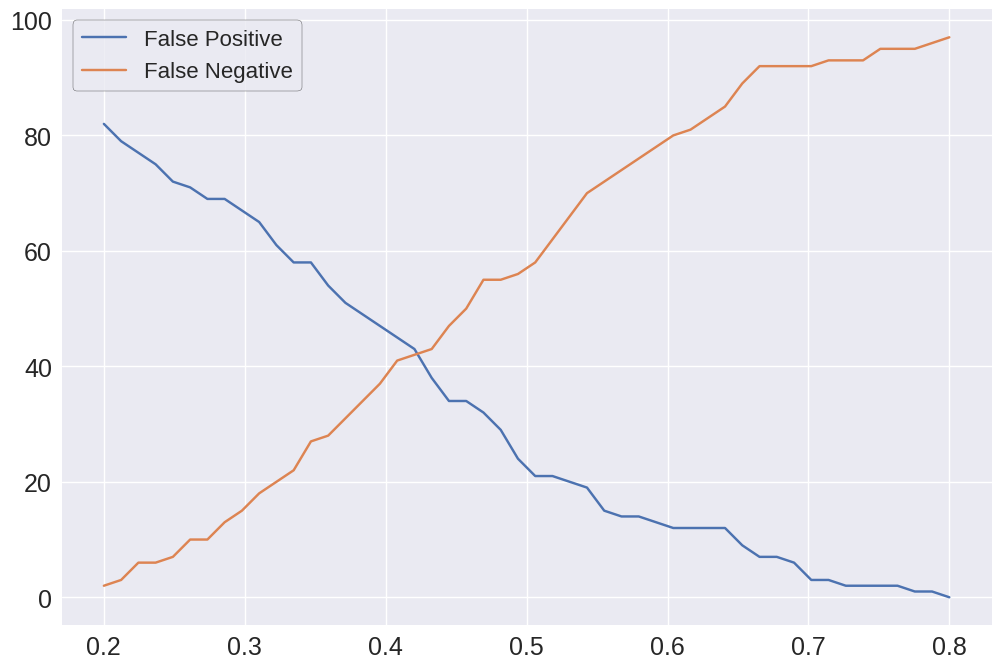

In [16]:
prob = log_reg.predict_proba(X_val) # Probabilities of each data point in the validation set

FP = np.zeros(0) # False positives
FN = np.zeros(0) # False negatives

T = np.linspace(0.2,0.8) # Varying the threshold

for threshold in T:

  y_treshold = np.zeros(X_val.shape[0])

  for i in range(len(y_treshold)):
    if prob[i,1] > threshold:
      y_treshold[i] = 1
    else:
      y_treshold[i] = 0

  cm = confusion_matrix(y_val, y_treshold)
  FP = np.append(FP, cm[0,1])
  FN = np.append(FN, cm[1,0])

plt.plot(T, FP, label = "False Positive")
plt.plot(T, FN, label = "False Negative")
plt.legend()
plt.show()



If we imagine that we are designing a medication, we would rather have more FN than FP, i.e., we prefer to lose a few functional sequences but at least we are more sure that the classified as functional sequences are really functional. Therefore, a good threshold would be 0.7

### B) Random Forest Classifier

Now let's try another model, that is to say, the Random Forest Classifier. It is an ensemble method, which is made to avoid overfitting, which is key here because the task is very complex and we have very limited data. It will train multiple random decision trees and then take an ensemble vote at the end to classify a point.

The "class_weight" attribute is set to "balanced" in order to take into account the fact that each class is not represented equally in the dataset (There is more NF than F)

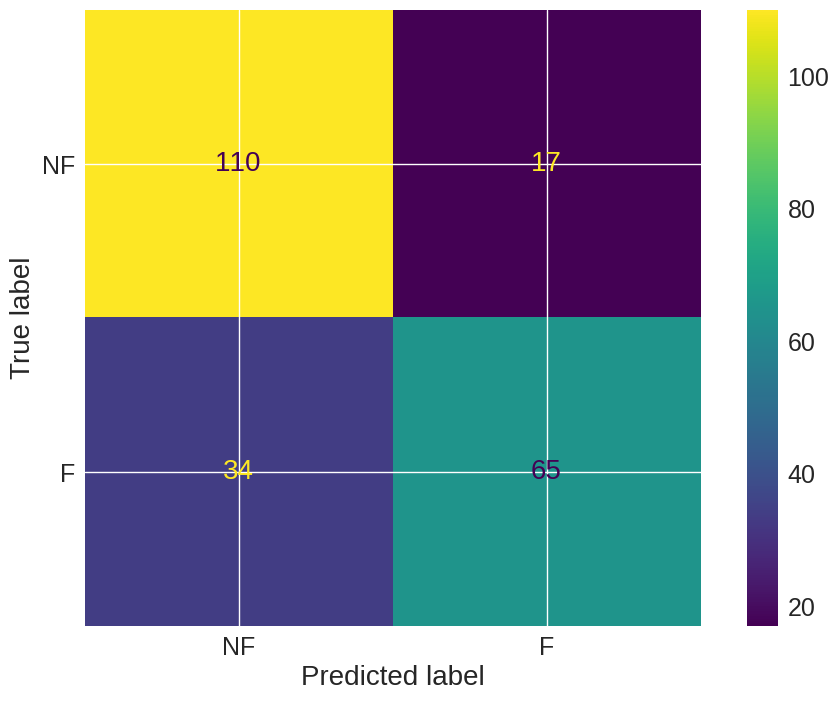

Accuracy of Random Forest on validation set :  0.7743362831858407


In [17]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=40, random_state=0, max_depth = 20, class_weight = 'balanced')
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["NF","F"])
disp.plot()
plt.show()

print("Accuracy of Random Forest on validation set : ", RFC.score(X_val, y_val))

Now we will vary the depth of the decision trees, train the different models on the train set and then evaluate their performance on the validation set to see which depth gives the best performance.


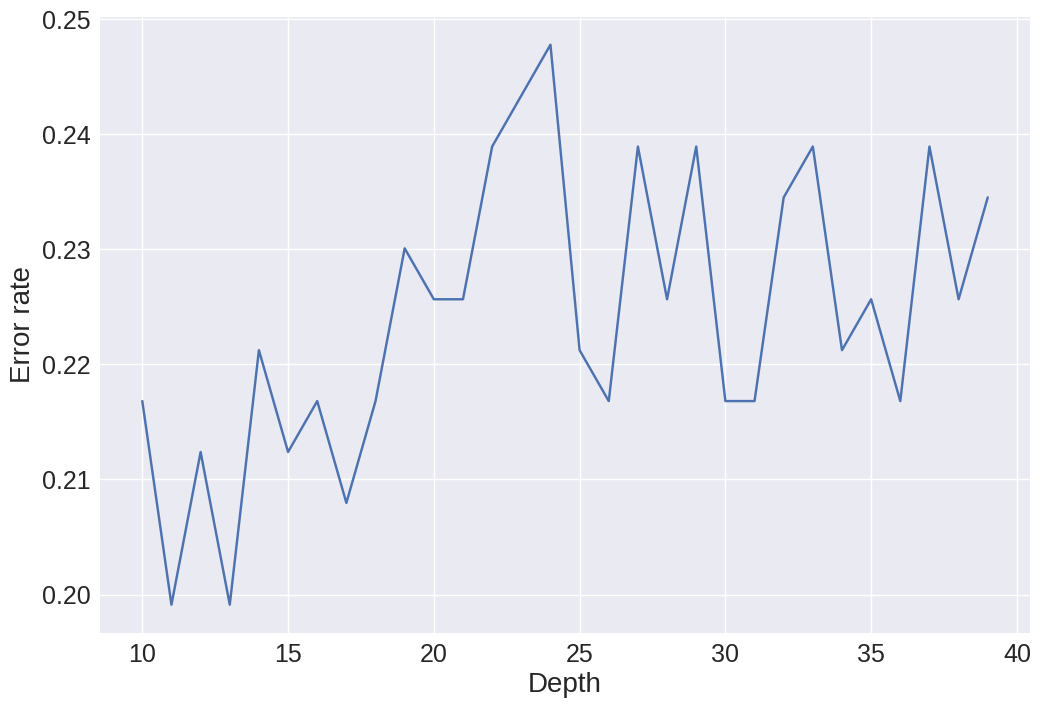

In [18]:
depth = range(10,40)
error_rate = np.zeros(0)

for d in depth:
  RFC = RandomForestClassifier(n_estimators=40, random_state=0, max_depth = d, class_weight = 'balanced')
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_val)
  error_rate = np.append(error_rate, 1-RFC.score(X_val, y_val) )

plt.plot(depth, error_rate)
plt.xlabel("Depth")
plt.ylabel("Error rate")
plt.show()

Best depth is 13. Note that we used 'balanced' for the classe_weight attribute of RFC, to account for the disparities in number of sequences in each class

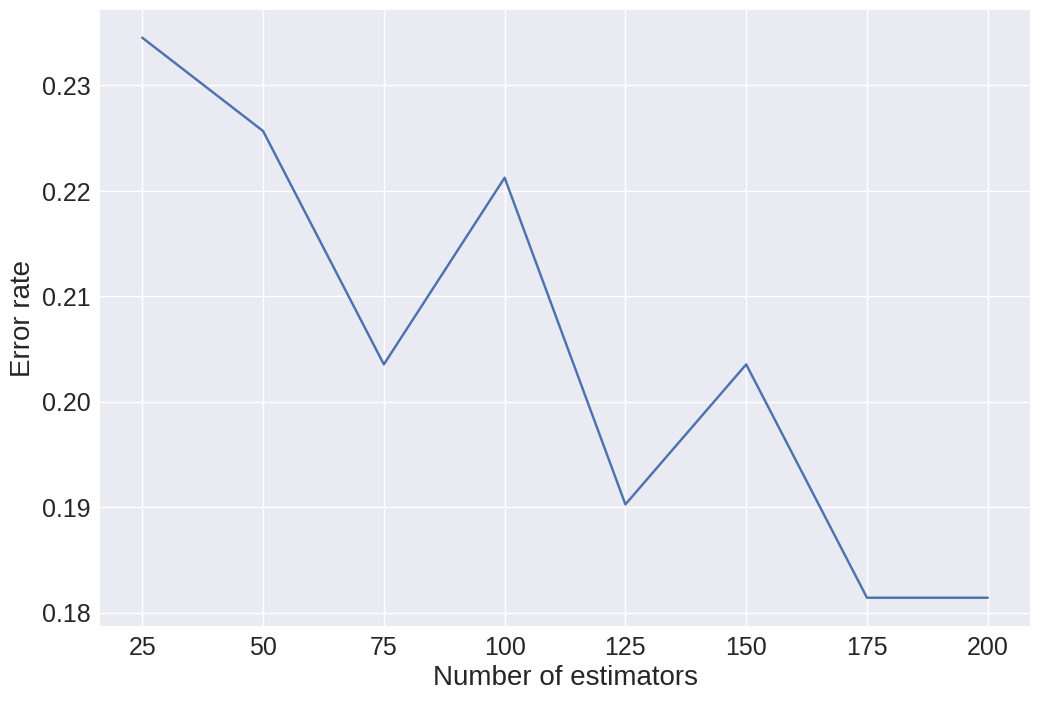

In [19]:
n_estimators = [25,50,75,100,125,150,175,200]
error_rate = np.zeros(0)

for n in n_estimators:
  RFC = RandomForestClassifier(n_estimators=n, max_depth = 13, class_weight = 'balanced')
  RFC.fit(X_train, y_train)
  error_rate = np.append(error_rate, 1-RFC.score(X_val, y_val) )

plt.figure()
plt.plot(n_estimators, error_rate)
plt.xlabel("Number of estimators")
plt.ylabel("Error rate")
plt.show()


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix


num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

accuracy_scores = []
confusion_matrices = []



for fold, (train_index, test_index) in enumerate(kf.split(X_nat)):
    X_train, X_test = X_nat[train_index], X_nat[test_index]
    y_train, y_test = y_nat[train_index], y_nat[test_index]

    # Initialize and train the classifier
    classifier = RandomForestClassifier(n_estimators=50, max_depth = 13, class_weight ="balanced")
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    confusion_matrices.append(cm)

    print(f"Fold {fold + 1}: Accuracy = {accuracy}")

# 3. Calculate average accuracy and confusion matrix
average_accuracy = np.mean(accuracy_scores)
print("\nAverage Accuracy across %i folds: %.3f" % (num_folds, average_accuracy))

# Average confusion matrix (may need adjustment based on how you want to combine)
average_cm = np.mean(confusion_matrices, axis=0)
print(f"Average Confusion Matrix:\n{average_cm}")

Fold 1: Accuracy = 0.7964601769911505
Fold 2: Accuracy = 0.7876106194690266
Fold 3: Accuracy = 0.7610619469026548
Fold 4: Accuracy = 0.8097345132743363
Fold 5: Accuracy = 0.827433628318584

Average Accuracy across 5 folds: 0.796
Average Confusion Matrix:
[[113.6  27.8]
 [ 18.2  66.4]]


In [21]:
RFC = RandomForestClassifier(n_estimators=250, random_state=0, max_depth = 13, class_weight ="balanced")
RFC.fit(X_train, y_train)

print("Accuracy of Random Forest on test set : ", RFC.score(X_art, y_art))

Accuracy of Random Forest on test set :  0.7946161515453639


Also bad accuracy on artificial sequence, which is a good sign of the quality of the artificial data.

### C) Artificial and Natural sequences classification

In [22]:
X = np.concatenate((X_nat, X_art))
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_art)))) # labels : 0 for natural data, 1 for artificial data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

cm = confusion_matrix(y_test, classifier.predict(X_test))
print(cm)

print("Accuracy of logistic regression on test set : ", classifier.score(X_test, y_test))


[[235   0]
 [  0 192]]
Accuracy of logistic regression on test set :  1.0


# Task 5 : Generative models




## A) VAEs


For this task and the following, we will use not rescaled data, in order to use a binary cross entropy loss function as a reconstruction function. It is used for binary variables, (like one_hot encoded sequences which are only 0 and 1). It needs inputs between 0 and 1, thus we cant use rescaled data.

In [23]:
from sklearn.model_selection import train_test_split

X_nat = encode(nat)
y_nat = label(nat)

X_art = encode(art)
y_art = label(art)

X_train, X_test, y_train, y_test = train_test_split(X_nat, y_nat, test_size=0.2, random_state=1)

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import minmax_scale



# definition of the encoder
latent_dim = 128
dropout_rate = 0.1  # Adjust the dropout rate as needed

encoder_inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(1024, activation="relu", kernel_initializer='random_normal')(encoder_inputs)
x = layers.Dropout(dropout_rate)(x)  # Add dropout after the first Dense layer
x = layers.Dense(512, activation="relu", kernel_initializer='random_normal')(x)
x = layers.Dropout(dropout_rate)(x)  # Add dropout after the second Dense layer
x = layers.Dense(256, activation="relu", kernel_initializer='random_normal')(x)
x = layers.Dropout(dropout_rate)(x) # Add dropout after the third Dense Layer
z_mean = layers.Dense(latent_dim, name="z_mean", kernel_initializer='random_normal')(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='random_normal')(x)

# Reparameterization trick
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), stddev = 0.2)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampler()(z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Define the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu", kernel_initializer='random_normal')(latent_inputs)
x = layers.Dropout(dropout_rate)(x)  # Add dropout after the first Dense layer
x = layers.Dense(512, activation="relu", kernel_initializer='random_normal')(x)
x = layers.Dropout(dropout_rate)(x)  # Add dropout after the second Dense layer
x = layers.Dense(1024, activation="relu", kernel_initializer='random_normal')(x)
x = layers.Dropout(dropout_rate)(x) #Add dropout after the third Dense Layer
decoder_outputs = layers.Dense(X_train.shape[1], activation="sigmoid", kernel_initializer='random_normal')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Define the VAE as a `Model` with a custom `train_step`
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = - 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2016)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,065,408 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampler (Sampler)         │ (None, 128)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,787,328 (10.63 MB)

 Trainable params: 2,787,328 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2016)                │       2,066,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,756,320 (10.51 MB)

 Trainable params: 2,756,320 (10.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - kl_loss: 114.8495 - loss: 136.5985 - reconstruction_loss: 21.7491
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - kl_loss: 7.4616 - loss: 25.3117 - reconstruction_loss: 17.8501
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - kl_loss: 1.6978 - loss: 8.8516 - reconstruction_loss: 7.1538
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - kl_loss: 0.5301 - loss: 5.3173 - reconstruction_loss: 4.7871
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - kl_loss: 0.2186 - loss: 4.7812 - reconstruction_loss: 4.5625
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - kl_loss: 0.1023 - loss: 4.6495 - reconstruction_loss: 4.5472
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - kl_loss: 0.0587 - loss: 4.5784 - reconstruction_loss: 4.5196
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - kl_loss: 0.0365 - loss: 4.5303 - reconstruction_loss: 4.4938
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - kl_loss: 0.0244 - loss: 4.51

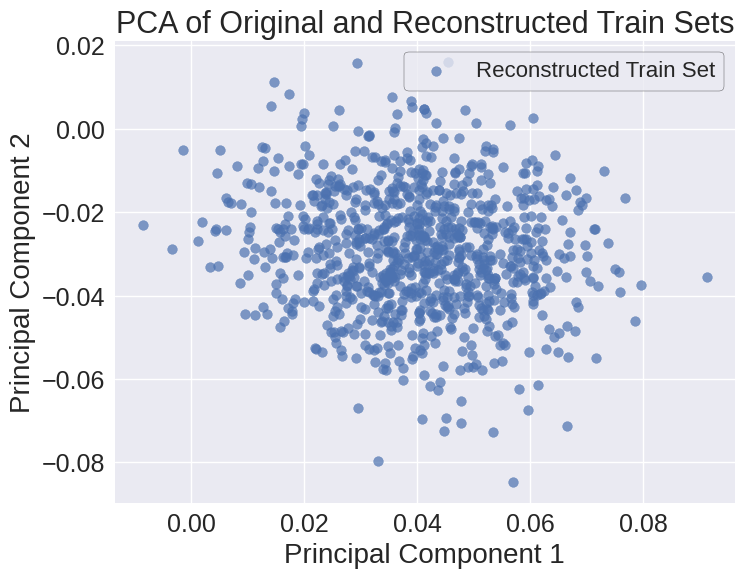

In [25]:
from sklearn.decomposition import PCA
"""
# Dimensionality reduction to help the generative model
pca_1000 = PCA(n_components=1000)
pca_1000.fit(X_nat)

X_nat_red = pca_1000.transform(X_nat)
X_art_red = pca_1000.transform(X_art)
"""




# Create a VAE instance
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# Train the VAE
vae.fit(X_train, epochs=10, batch_size=32) # Adjust epochs and batch_size



# Encode and decode the training set
z_mean_train, z_log_var_train, z_train = encoder.predict(X_train)
reconstructed_train = decoder.predict(z_train)


# Apply PCA to the original and reconstructed training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
reconstructed_train_pca = pca.transform(reconstructed_train)


# Plot the original and reconstructed training data in PCA space
plt.figure(figsize=(8, 6))
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Original Train Set', alpha=0.7)
plt.scatter(reconstructed_train_pca[:, 0], reconstructed_train_pca[:, 1], label='Reconstructed Train Set', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original and Reconstructed Train Sets')
plt.legend()
plt.show()

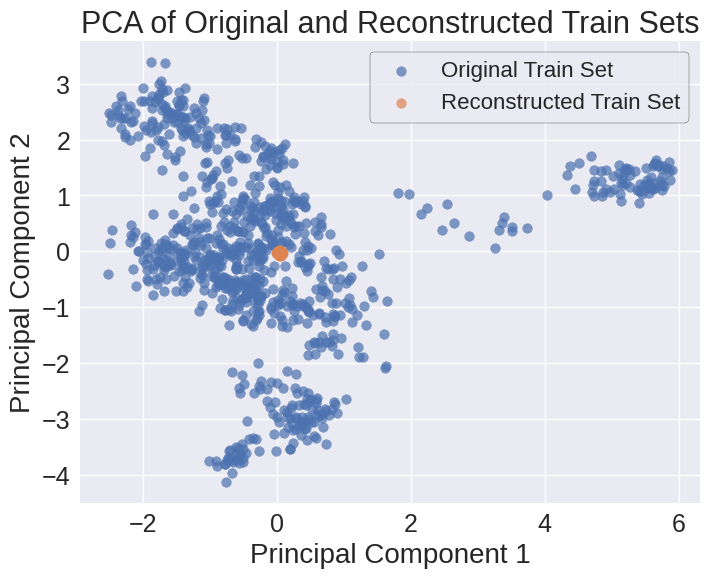

In [26]:
# Plot the original and reconstructed training data in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Original Train Set', alpha=0.7)
plt.scatter(reconstructed_train_pca[:, 0], reconstructed_train_pca[:, 1], label='Reconstructed Train Set', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original and Reconstructed Train Sets')
plt.legend()
plt.show()

In [27]:
z_mean_test, z_log_var_test, z_test = encoder.predict(X_test)
reconstructed_test = decoder.predict(z_test)
# loss on test set
reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(X_test, reconstructed_test))
print("Reconstruction loss on test set:", reconstruction_loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Reconstruction loss on test set: tf.Tensor(0.14019173, shape=(), dtype=float32)


A simple VAE is not able to reconstruct well the data. It tries to fit a very complicated data distribution in latent space with a unimodal gaussian distribution, thus the reconstructed sequences are all mapped to an area where there is many points. Let's try something way simpler, but keeping the same idea as a VAE.

## B) Auto-encoder and Gaussian Mixture Model

For a task this complex with so limited data, the key is to do simple models. Instead of fitting directly the prior distribution in latent space, we can first find a mapping in latent space and then use a Gaussian Mixture Model (GMM) on it. Gaussian mixture, is initially a clustering algorithm, but it is also generative. It tries to fit a data set with a mixture of $k$ gaussian distributions, where $k$ is a hyperparameter. As we saw before, clustering can be very complicated, but it is always easier in lower dimension. That is why we thought that doing GMM on a latent space could work.

We now have to find a mapping to a latent space of (hopefully) low dimension. We saw that PCA needed too mny components to keep enough information to be used. Also t-SNE is harder to train, not reproducible, and less interpretable, so it is not an option. Instead, we used an AutoEncoder (AE). It is a Neural network divided in an encoder and decoder. It consists in a succession of layers that progressively decrease the dimension from the input dimension to the latent dimension, and then the opposite, back to the input space. It is a self supervised task, as the main goal of this model is to reconstruct the initial data it was fed, i.e, the labels are the data itself. But to start, we decided to do only one hidden layer, and it turned out to work quite well.

Epoch [1/50]
Epoch [2/50]
Epoch [3/50]
Epoch [4/50]
Epoch [5/50]
Epoch [6/50]
Epoch [7/50]
Epoch [8/50]
Epoch [9/50]
Epoch [10/50]
Epoch [11/50]
Epoch [12/50]
Epoch [13/50]
Epoch [14/50]
Epoch [15/50]
Epoch [16/50]
Epoch [17/50]
Epoch [18/50]
Epoch [19/50]
Epoch [20/50]
Epoch [21/50]
Epoch [22/50]
Epoch [23/50]
Epoch [24/50]
Epoch [25/50]
Epoch [26/50]
Epoch [27/50]
Epoch [28/50]
Epoch [29/50]
Epoch [30/50]
Epoch [31/50]
Epoch [32/50]
Epoch [33/50]
Epoch [34/50]
Epoch [35/50]
Epoch [36/50]
Epoch [37/50]
Epoch [38/50]
Epoch [39/50]
Epoch [40/50]
Epoch [41/50]
Epoch [42/50]
Epoch [43/50]
Epoch [44/50]
Epoch [45/50]
Epoch [46/50]
Epoch [47/50]
Epoch [48/50]
Epoch [49/50]
Epoch [50/50]
Training finished!


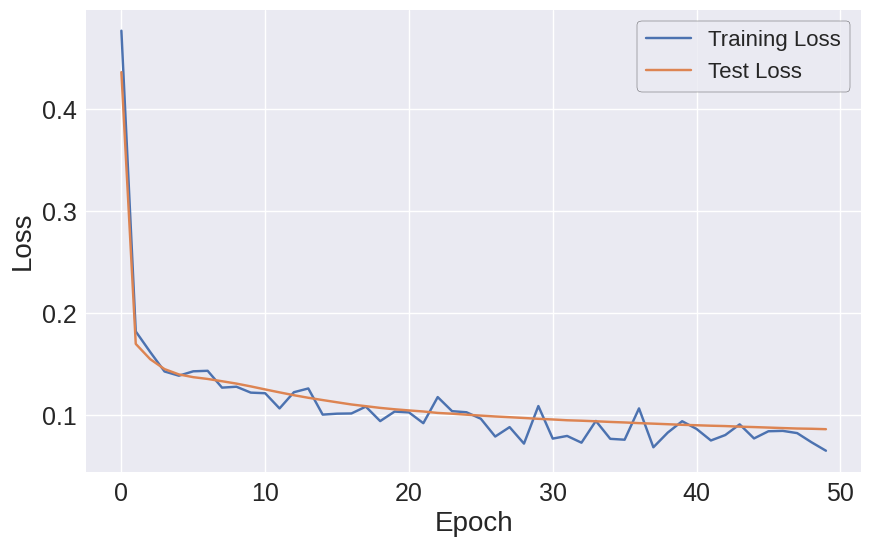

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Use sigmoid for output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Hyperparameters
input_dim = X_train.shape[1]  # Replace with the actual input dimension
encoding_dim = 128
learning_rate = 1e-3
batch_size = 100
num_epochs = 50

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the autoencoder, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AE = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.BCELoss() # Use Binary Cross Entropy loss
optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

train_err = []
test_err = []


# Training loop
for epoch in range(num_epochs):
  for data in train_loader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = AE(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()

  train_err.append(loss.item())
  reconstructed_test = AE(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().numpy()
  test_err.append(criterion(torch.tensor(reconstructed_test, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)).item())

  print(f"Epoch [{epoch+1}/{num_epochs}]")

print("Training finished!")

plt.figure(figsize=(10, 6))
plt.plot(train_err, label='Training Loss')
plt.plot(test_err, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the AE diminished the data dimension from 2016 to 128, while losing only about 9% of the information. for the same dimension, PCA would have lost about 50% of the information, To ensure the AE did learn the correct features, we can try to plot in PCA space the original training sequences, and the reconstructed ones.

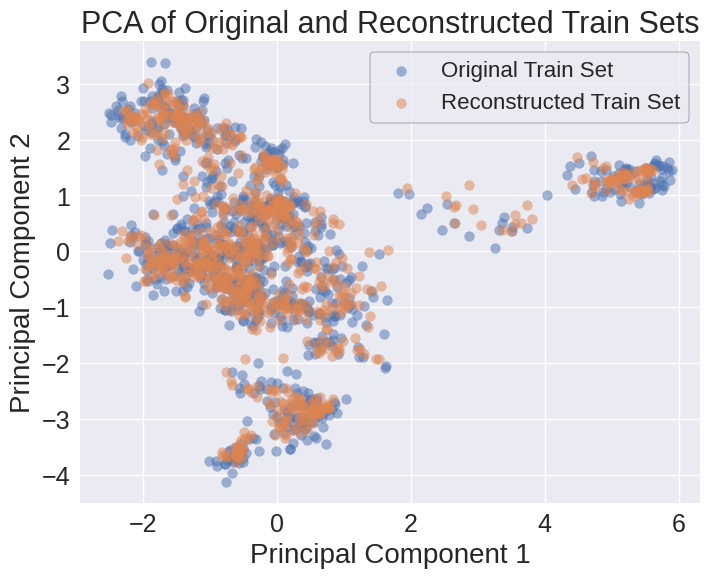

In [29]:
from sklearn.decomposition import PCA

reconstructed_train = AE(X_train_tensor).detach().numpy()

# Apply PCA to the original and reconstructed training data

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
reconstructed_train_pca = pca.transform(reconstructed_train)


# Plot the original and reconstructed training data in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Original Train Set', alpha=0.5)
plt.scatter(reconstructed_train_pca[:, 0], reconstructed_train_pca[:, 1], label='Reconstructed Train Set', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original and Reconstructed Train Sets')
plt.legend()
plt.show()

We can also try to see if the AE generalizes well to new sequences.

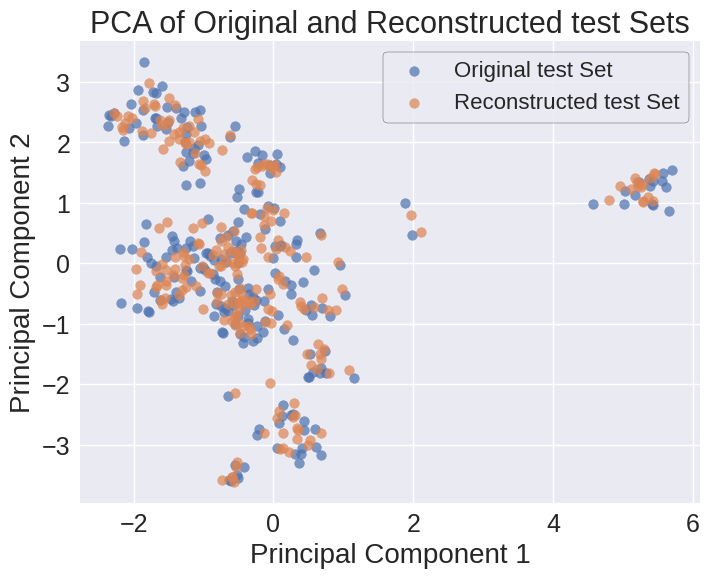

In [30]:
X_test_pca = pca.transform(X_test)
reconstructed_test = AE(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().numpy()
reconstructed_test_pca = pca.transform(reconstructed_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Original test Set', alpha=0.7)
plt.scatter(reconstructed_test_pca[:, 0], reconstructed_test_pca[:,1], label='Reconstructed test Set', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original and Reconstructed test Sets')
plt.legend()
plt.show()

Now let's encode our natural data using the encoder part of the AE, and then train a GMM on the encoded sequences. For the number of modes in the GMM, I chose 15, as it is the number of clusters obtained from the DBSCAN approach in Task 3

In [31]:
# Convert X_nat to a PyTorch tensor
X_nat_tensor = torch.tensor(X_nat, dtype=torch.float32)

# Move the tensor to the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_nat_tensor = X_nat_tensor.to(device)

# Encode X_nat using the encoder part of the autoencoder
with torch.no_grad(): # Disable gradient calculation for inference
    X_nat_encoded = AE.encoder(X_nat_tensor)

# Move the encoded data back to the CPU if needed
X_nat_encoded = X_nat_encoded.cpu().numpy()

# X_nat_encoded now contains the encoded representation of X_nat in the latent space

X_nat_encoded.shape

(1130, 128)

In [32]:
from sklearn.mixture import GaussianMixture


# Train a Gaussian Mixture Model
gmm = GaussianMixture(n_components=15, random_state=0) # Adjust n_components as needed
gmm.fit(X_nat_encoded)

# Generate new data points from the GMM
n_samples = 1000
generated_data = torch.tensor(gmm.sample(n_samples)[0], dtype=torch.float32)


# Decode the generated data points using the decoder
generated_decoded = AE.decoder(generated_data).detach().numpy()

# Now 'generated_decoded' contains the decoded representation of the generated data

generated_decoded.shape

(1000, 2016)

In less than a second, we fitted our model and generated 1000 sequences. We now have to evaluate the quality of these generated sequences.

## C) Verification of the generated data


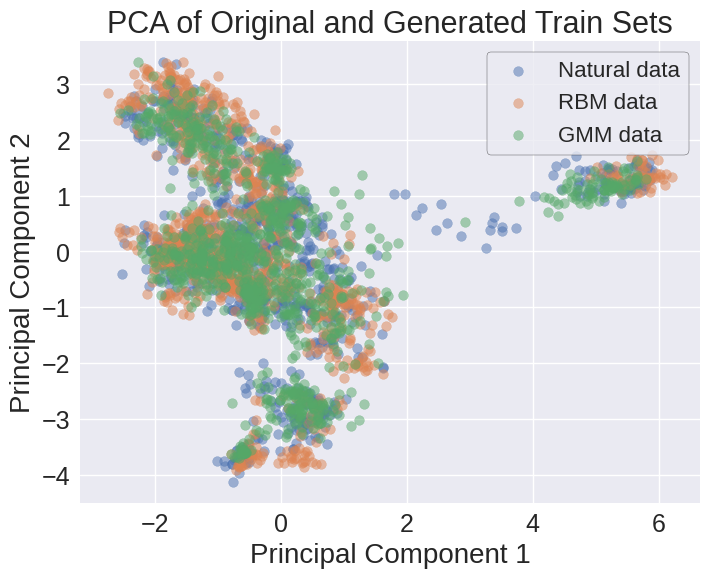

In [33]:
X_art_pca = pca.transform(X_art)
generated_pca = pca.transform(generated_decoded)

# Plot the original and generated training data in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Natural data', alpha=0.5)
plt.scatter(X_art_pca[:, 0], X_art_pca[:, 1], label='RBM data', alpha=0.5)
plt.scatter(generated_pca[:, 0], generated_pca[:, 1], label='GMM data', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original and Generated Train Sets')
plt.legend()
plt.show()

We can now look at the frequencies of each amino acid, i.e. the frequency of finding the amino acid $a$ at position $i$ in the natural dataset, and then compare it to the frequencies in the artificial dataset (generated with DCA), and the generated dataset.

In [34]:
import matplotlib.pyplot as plt

def create_2d_histogram(data, title):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
    aa_counts = {}
    for seq in data:
        for i in range(96):
            aa = seq[i]  # Accessing the i-th amino acid
            if aa not in amino_acids:
                continue  # Skip invalid amino acids
            pos = i + 1  # Adjust position to be 1-indexed

            if pos not in aa_counts:
                aa_counts[pos] = {}
            if aa not in aa_counts[pos]:
                aa_counts[pos][aa] = 0
            aa_counts[pos][aa] += 1


    positions = sorted(aa_counts.keys())
    amino_acids = sorted(list(set([aa for pos in positions for aa in aa_counts[pos].keys()])))
    frequencies = [[aa_counts[pos].get(aa,0) for aa in amino_acids] for pos in positions]
    frequencies = np.array(frequencies)
    frequencies = frequencies/np.sum(frequencies)

    plt.figure(figsize=(15,5))
    plt.imshow(frequencies.T, cmap='viridis', aspect='auto')
    plt.yticks(range(len(amino_acids)), amino_acids, fontsize = 10 )
    plt.ylabel("Amino Acid")
    plt.xlabel("Position")
    plt.title("2D Histogram of Amino Acid Frequencies : " + title)
    plt.colorbar(label="Frequency")
    plt.tight_layout()
    plt.grid(visible=False)
    plt.show()
    return frequencies


Number of unique generated sequences : 1000


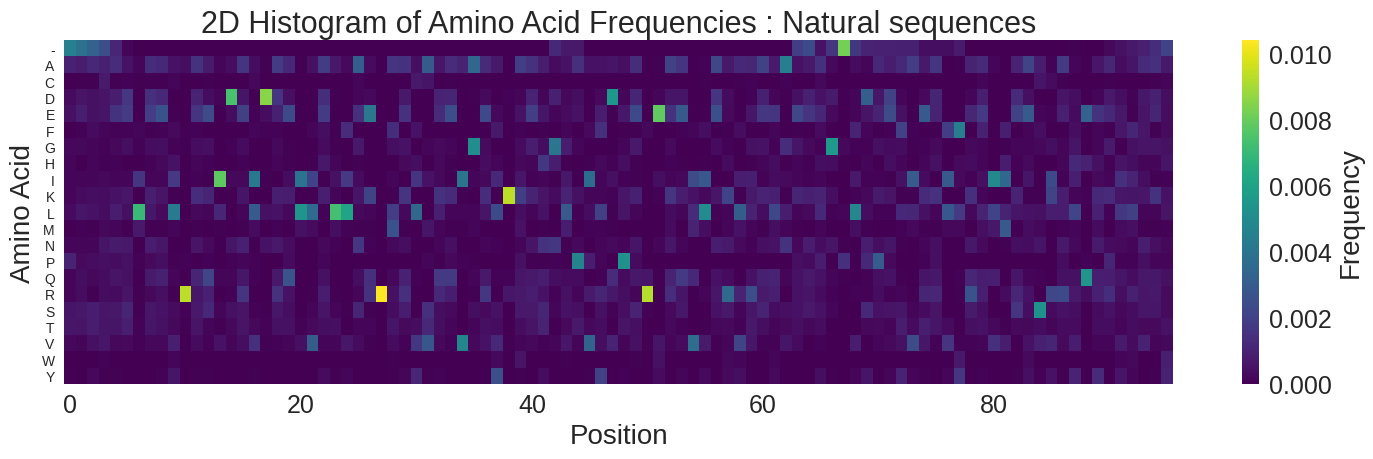

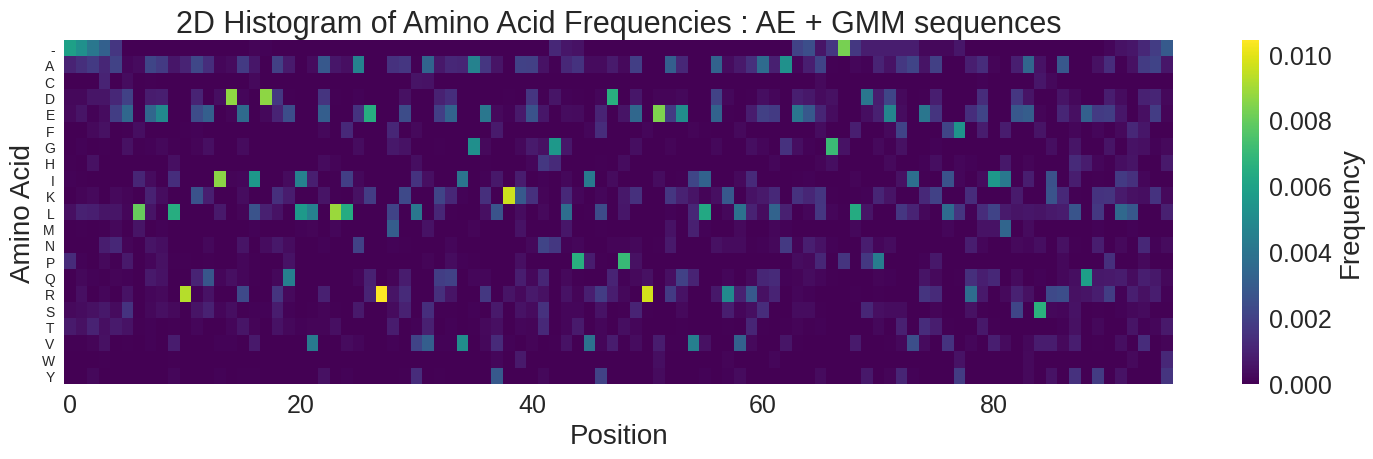

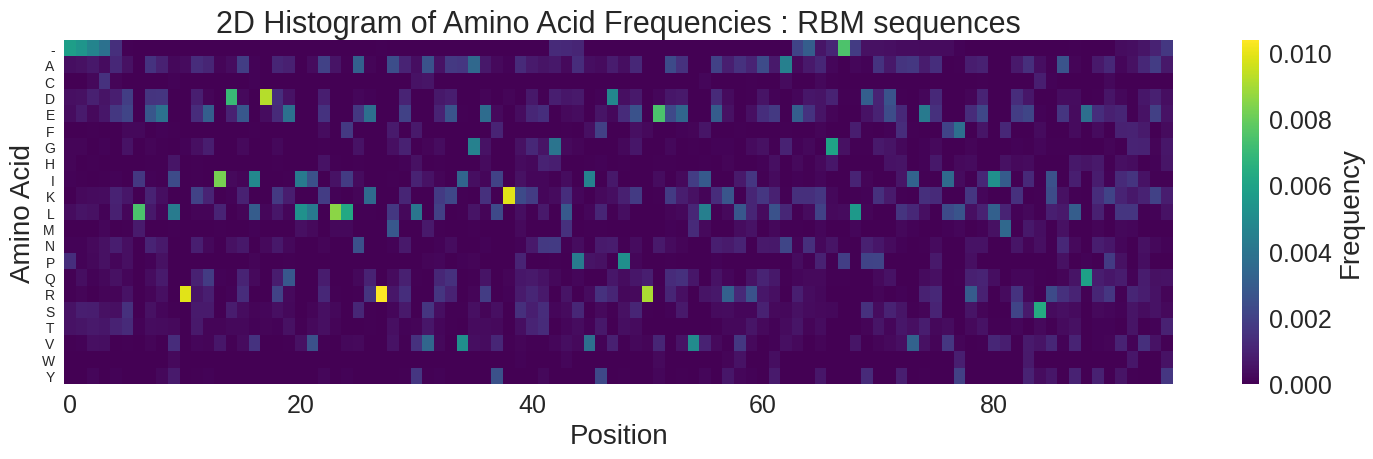

In [35]:
gen_seq = [de_one_hot(generated_decoded[i,:].reshape((96,21))) for i in range(len(generated_decoded))]
unique = len(np.unique(gen_seq, axis = 0))
print("Number of unique generated sequences : %i" %(unique))


nat_seq = [nat[i].seq for i in range(len(nat))]
art_seq = [art[i].seq for i in range(len(art))]

first_order_nat = create_2d_histogram(nat_seq, 'Natural sequences')
first_order_gen = create_2d_histogram(gen_seq, 'AE + GMM sequences')
first_order_art = create_2d_histogram(art_seq, 'RBM sequences')

Visually it looks promising. Let's look at the correlations between nat and gen data

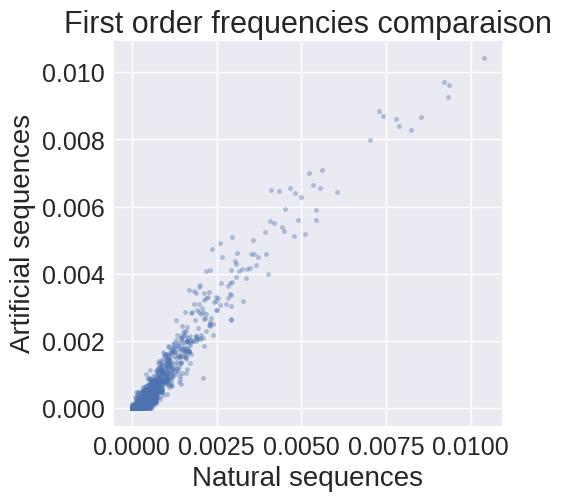

Correlation coeficient : 0.973


In [36]:
def corr_np(data1, data2):
    mean1 = data1.mean()
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr

plt.figure(figsize=(5,5))
plt.plot(first_order_nat.flatten(), first_order_gen.flatten(), '.', alpha = 0.4)
plt.xlabel('Natural sequences')
plt.ylabel('Artificial sequences')
plt.title('First order frequencies comparaison')
plt.show()


corr_GMM = corr_np(first_order_nat.flatten(), first_order_gen.flatten())
print("Correlation coeficient : %5.3f" %(corr_GMM))

And compare it to nat vs art data

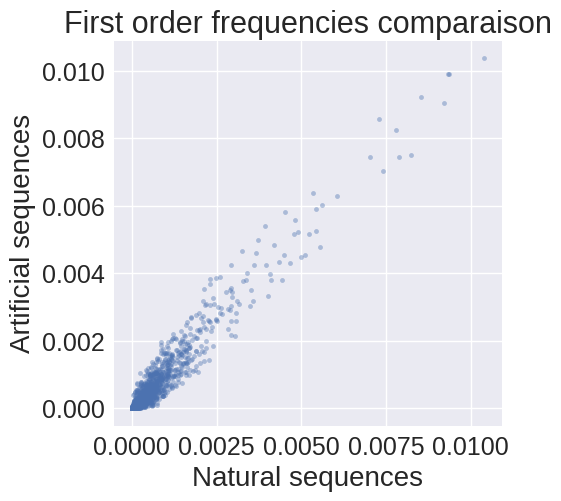

Correlation coeficient : 0.971


In [37]:
plt.figure(figsize=(5,5))
plt.plot(first_order_nat.flatten(), first_order_art.flatten(), '.', alpha = 0.4)
plt.xlabel('Natural sequences')
plt.ylabel('RBM sequences')
plt.title('First order frequencies comparaison')
plt.show()

corr_RBM = corr_np(first_order_nat.flatten(), first_order_art.flatten())
print("Correlation coeficient : %5.3f" %(corr_RBM))

Now, let's do the same for the second order correlations, i.e. how often do we find amino acid $a$ at pos. $i$  $\textbf{ and}$ amino acid $b$ at pos. $j$. This is very important in protein sequences analysis, because it is a testimony of the protein 3D structure. In fact amino acids can interact with very far in the sequence amino acids, because the folding of the protein gets them close in space. These interactions ensure the stability of the protein, and thus are essential to construct a realistic protein.

In [38]:
second_order_nat = np.zeros((96, 96, 21, 21))

amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

for seq in nat_seq:
  for i in range(96):
    for j in range(96):
      aa1 = seq[i]
      aa2 = seq[j]
      if aa1 in amino_acids and aa2 in amino_acids:
        second_order_nat[i, j, aa_to_index[aa1], aa_to_index[aa2]] += 1

second_order_nat = second_order_nat/np.sum(second_order_nat)

for i in range(96):
    for j in range(96):
      for a in range(21):
        for b in range(21):
          second_order_nat[i, j, a, b] -= first_order_nat[i, a] * first_order_nat[j, b]



second_order_gen = np.zeros((96, 96, 21, 21))

for seq in gen_seq:
  for i in range(96):
    for j in range(96):
      aa1 = seq[i]
      aa2 = seq[j]
      if aa1 in amino_acids and aa2 in amino_acids:
        second_order_gen[i, j, aa_to_index[aa1], aa_to_index[aa2]] += 1

second_order_gen = second_order_gen/np.sum(second_order_gen)

for i in range(96):
    for j in range(96):
      for a in range(21):
        for b in range(21):
          second_order_gen[i, j, a, b] -= first_order_gen[i, a] * first_order_gen[j, b]



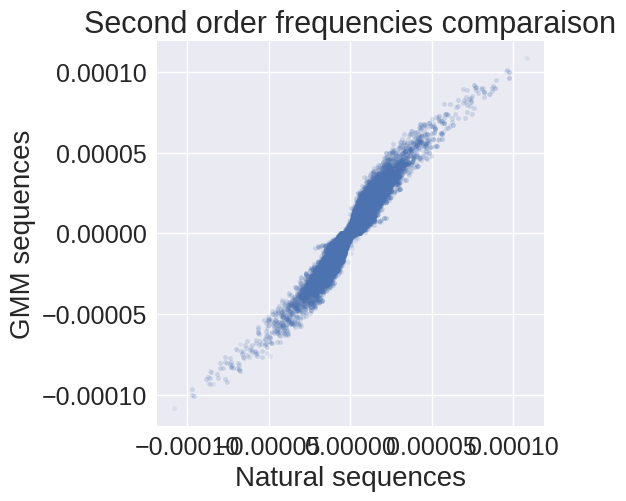

Correlation coeficient : 0.944


In [39]:
plt.figure(figsize=(5,5))
plt.plot(second_order_nat.flatten(), second_order_gen.flatten(), '.', alpha = 0.1)
plt.xlabel('Natural sequences')
plt.ylabel('GMM sequences')
plt.title('Second order frequencies comparaison')
plt.show()

corr_GMM = corr_np(second_order_nat.flatten(), second_order_gen.flatten())
print("Correlation coeficient : %5.3f" %(corr_GMM))

They are reconstructed quite well, even with our simple model.

In [40]:
second_order_art = np.zeros((96, 96, 21, 21))

for seq in art_seq:
  for i in range(96):
    for j in range(96):
      aa1 = seq[i]
      aa2 = seq[j]
      if aa1 in amino_acids and aa2 in amino_acids:
        second_order_art[i, j, aa_to_index[aa1], aa_to_index[aa2]] += 1

second_order_art = second_order_art/np.sum(second_order_art)

for i in range(96):
    for j in range(96):
      for a in range(21):
        for b in range(21):
          second_order_art[i, j, a, b] -= first_order_art[i, a] * first_order_art[j, b]

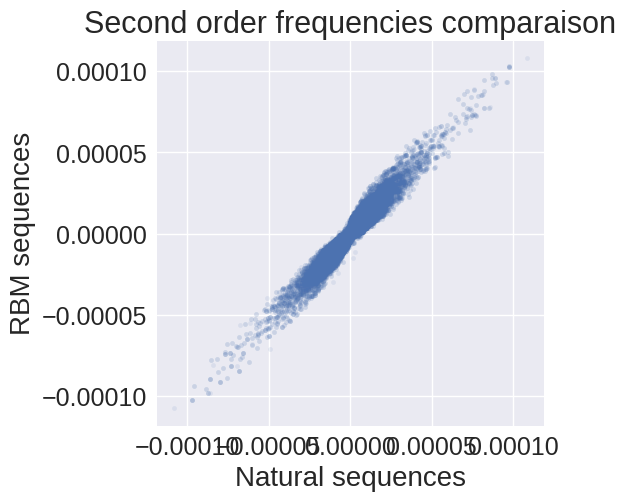

Correlation coeficient : 0.935


In [41]:
plt.figure(figsize=(5,5))
plt.plot(second_order_nat.flatten(), second_order_art.flatten(), '.', alpha = 0.1)
plt.xlabel('Natural sequences')
plt.ylabel('RBM sequences')
plt.title('Second order frequencies comparaison')
plt.show()

corr_RBM = corr_np(second_order_nat.flatten(), second_order_art.flatten())
print("Correlation coeficient : %5.3f" %(corr_RBM))

It performs approximatively as good as the DCA generated sequences using bmDCA.

Now let's try to train a classifier to predict if our generated sequence is real or fake

In [42]:
X_gen = [one_hot(gen_seq[i]) for i in range(len(gen_seq))]

# Concatenate the datasets
X = np.concatenate((X_nat, X_gen))

# Create labels: 0 for X_nat, 1 for X_gen
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_gen))))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train RFC
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")



cm = confusion_matrix(y_test, y_pred)
print(cm)


Accuracy: 0.9624413145539906
[[231  12]
 [  4 179]]


In [43]:

# Concatenate the datasets
X = np.concatenate((X_nat, X_art))

# Create labels: 0 for X_nat, 1 for X_gen
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_art))))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train RFC
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")



cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.7728337236533958
[[160  61]
 [ 36 170]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


A simple logistic regression is almost able to distinguish between our data and the natural ones, while it has a harder time distinguishing natural and artificial data. Our generated sequences are not realistic enough yet.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X_nat, y_nat, test_size=0.2, random_state=4)

X_train_encoded = AE.encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach().numpy()
X_test_encoded = AE.encoder(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().numpy()

classifier = RandomForestClassifier()
classifier.fit(X_train_encoded, y_train)

y_pred = classifier.predict(X_test_encoded)

cm = confusion_matrix(y_test, y_pred)
print(cm)


print("Accuracy of RFC on train set : %2.3f" %(classifier.score(X_train_encoded, y_train)))
print("Accuracy of RFC on test set : %2.3f" %(classifier.score(X_test_encoded, y_test)))



[[124  18]
 [ 35  49]]
Accuracy of RFC on train set : 1.000
Accuracy of RFC on test set : 0.765
